# NetBeez API examples
## Example 1: Retrive PING test results from a specific agent for the past 60 minutes
## Example 2: Display top 10 agents with most alerts from the last 24 hours

This notebook uses a Python environment to demonstrate how a NetBeez user can retrive data from the API and manipulate them and visualize them in a meaningful way.

First we describe the setup process for getting data from the API.

## Setup your NetBeez Beezkeeper details

First you need to identify your server's FQDN and generate an API key to use in these examples.

If the URL you use to access NetBeez looks like this https://demo.netbeecloud.net then `demo.netbeecloud.net` is the fqdn.

In [1]:
beezkeeper_fqdn="demo.netbeezcloud.net"  ## <--------- CHANGE THIS TO YOUR INSTANCE FQDN
base_url='https://' + beezkeeper_fqdn

In [2]:
from IPython.display import Markdown as md

md(f"To generate an API key head over to https://{beezkeeper_fqdn}/#settings-tab/api-keys-settings")

md(f"For documentation go to https://api.netbeez.net or https://{beezkeeper_fqdn}/swagger/")

For documentation go to https://api.netbeez.net or https://demo.netbeezcloud.net/swagger/

In [3]:
api_key="7g5_hKXw_460SNKEkJEYlMn1eqw3iTmaus_cCMZ8REhc5MOEtEAx8g"  # <--------- CHANGE THIS TO YOUR KEY

## Setup the headers
We define the content type format as JSON and provide the API key that you generated in the previous step as part of the headers.

In [4]:
import requests
import urllib3

urllib3.disable_warnings()


headers = {
            'Cache-Control': 'no-store',
            'Content-type': 'application/json',
            'Authorization': 'Bearer ' + api_key
          }

legacy_api_headers = {
    'Authorization': api_key,
    'API-VERSION': 'v1',
    'Content-type': 'application/json'
}

Note that when the legacy api headers are used it means that we are using the legacy API which is subject to be replaced soon by the new JSON API (documentation here: https://api.netbeez.net)

# Example 1: Get NetBeez Agent information and last 24 hours Ping results.

In this example we will be searching for an agent by name, then selecting the ping tests that are currently running, and then retriving the raw measurement results for those tests from the past 60 minutes.

## Retrieve the agent
First we set retrieve the agent by search by name using this API endpoint: https://api.netbeez.net/#f3d48709-5344-45b7-af9b-7b92feddd4ec.

In [5]:
search_name = "Virtual Agent"
url = f"{base_url}/agents?filter[name]={search_name}&type=beta"


In [6]:
response = requests.request("GET", url, headers=headers, verify=False)

import json
data = json.loads(response.text)
agent = data['data'][0]
print(agent)

{'id': '341', 'type': 'agent', 'attributes': {'name': 'Pittsburgh - Virtual Agent', 'reached_target_test_limit': False, 'reached_scheduled_test_limit': None, 'nb_target_ids': [463, 464, 465, 437, 32], 'nb_test_ids': [1667068, 1667069, 1667070, 1667065, 1667066, 1667067, 1667071, 1688201, 1688302, 1688303, 1688304, 1688305, 1688306, 1688391, 1688392, 1688393, 1688394, 1688395, 1688474, 1688475, 1688476, 1688477, 1688478], 'agent_type_name': 'virtual-model-ova', 'os_version': 'Debian GNU/Linux 8.11 (jessie)', 'kernel_version': '#1 SMP Debian 3.16.51-3 (2017-12-13)', 'uuid': '00:0c:29:09:fa:ee', 'agent_class': 'virtual', 'active': True, 'active_ts': 1625542888771, 'description': None, 'category': 'network_agent', 'software_version': '8.0.6', 'open_incident_id': None, 'test_aggregate_counts_by_type': {'1': {'success': 5, 'fail': 0, 'warning': 0, 'paused': 0, 'unknown': 0}, '2': {'success': 5, 'fail': 0, 'warning': 0, 'paused': 0, 'unknown': 0}, '3': {'success': 5, 'fail': 0, 'warning': 0, 

## Retrieve Ping tests
Then we iterate through the tests and select the ping tests.

In [7]:
nb_tests = []
for nb_test_id in agent['attributes']['nb_test_ids']:
    url = f"{base_url}/nb_tests/{nb_test_id}.json"
    response = requests.request("GET", url, headers=legacy_api_headers, verify=False)
    data = json.loads(response.text)
    if data['heir_type'] == 'PingTest':
        print(data)
        nb_tests.append(data)


{'id': 1667068, 'target': 'www.google.com', 'count': 0, 'interval': 5, 'timeout': 5, 'start_ts': '2021-04-01T15:39:11.736-04:00', 'created_at': '2021-04-01T19:39:11.000Z', 'updated_at': '2021-06-03T15:34:27.000Z', 'agent_id': 341, 'test_type_id': 1, 'heir_id': 11374, 'heir_type': 'PingTest', 'ad_hoc': False, 'test_name': None, 'nb_test_templatable_type': 'NbTestTemplate', 'nb_test_templatable_id': 99, 'current_alert_mode': 'success', 'wifi_profile_id': None, 'network_interface_id': 387, 'nb_target_id': 32, 'nb_test_template_id': 99, 'schedule_type': 'periodic', 'options': {'data_size': 54, 'dont_fragment': False, 'tos': None, 'port': None, 'ping_type': 2, 'flags': None, 'jitter_mos': True}, 'alert_mode': 'success', 'interface_type': 'wired'}
{'id': 1667065, 'target': 'demo-app.netbeezcloud.net', 'count': 0, 'interval': 5, 'timeout': 5, 'start_ts': '2021-04-01T15:39:11.604-04:00', 'created_at': '2021-04-01T19:39:11.000Z', 'updated_at': '2021-06-03T15:34:27.000Z', 'agent_id': 341, 'test_

## Retrive the results
Then we retrieve the results for the past 60 minutes.

In [8]:
import time
import datetime
to_ts = int(time.time() * 1000)
from_ts = to_ts - (60 * 60 * 1000)

print(datetime.datetime.fromtimestamp(from_ts/1000.0))
print(datetime.datetime.fromtimestamp(to_ts/1000.0))


2021-07-06 12:51:34.041000
2021-07-06 13:51:34.041000


In [9]:
results = []
import pandas as pd
for nb_test in nb_tests:
    url = f"{base_url}/results.json?nb_test_id={nb_test['id']}&from={from_ts}&to={to_ts}"
    response = requests.request("GET", url, headers=legacy_api_headers, verify=False)
    df = pd.json_normalize(json.loads(response.text), 'index')
    if df.empty == False :
        df['timestamp'] = df['timestamp'].transform(lambda x: datetime.datetime.fromtimestamp(x/1000.0))
        df.set_index('id', inplace=True)
        results.append(df)
    
results = pd.concat(results)

...and here is a printout of the results:

In [10]:
print(results)

            value               timestamp  sequence_number  nb_test_id
id                                                                    
9907064934  12.10 2021-07-06 12:51:36.793          1651474     1667068
9907065166  12.10 2021-07-06 12:51:41.800          1651475     1667068
9907065273  12.90 2021-07-06 12:51:46.800          1651476     1667068
9907065466  12.10 2021-07-06 12:51:51.805          1651477     1667068
9907065610  12.10 2021-07-06 12:51:56.808          1651478     1667068
...           ...                     ...              ...         ...
9907187479   9.78 2021-07-06 13:51:11.567           852397     1688474
9907187602   9.70 2021-07-06 13:51:16.570           852398     1688474
9907187883   9.72 2021-07-06 13:51:21.571           852399     1688474
9907188025   9.68 2021-07-06 13:51:26.579           852400     1688474
9907188122   9.67 2021-07-06 13:51:31.582           852401     1688474

[3595 rows x 4 columns]


In [11]:
results_pivot = results.pivot(index='timestamp', columns='nb_test_id', values='value')
pf = results_pivot.interpolate()
print(pf)

nb_test_id               1667065  1667068  1688303  1688391  1688474
timestamp                                                           
2021-07-06 12:51:36.228    10.70      NaN      NaN      NaN      NaN
2021-07-06 12:51:36.743    10.68      NaN      NaN      NaN    9.240
2021-07-06 12:51:36.793    10.66     12.1      NaN      NaN    9.222
2021-07-06 12:51:37.320    10.64     12.1      NaN    111.0    9.204
2021-07-06 12:51:38.642    10.62     12.1    224.0    109.6    9.186
...                          ...      ...      ...      ...      ...
2021-07-06 13:51:30.371    10.70     20.7    240.0    103.4    9.674
2021-07-06 13:51:31.541    10.70     20.7    240.0    103.6    9.672
2021-07-06 13:51:31.582    10.70     20.7    240.0    103.8    9.670
2021-07-06 13:51:31.703    10.70     20.7    240.0    104.0    9.670
2021-07-06 13:51:32.917    10.70     20.7    240.0    104.0    9.670

[3565 rows x 5 columns]


<AxesSubplot:xlabel='timestamp'>

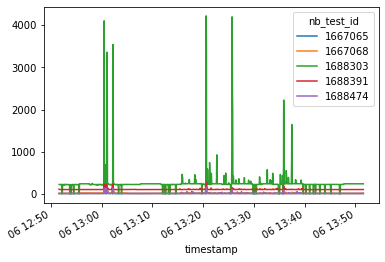

In [12]:
pf.plot()

# Example 2: Get the top 10 Agents with the most alerts triggered during the past 24 hours.

In this example we will be retrieve all the alerts triggered during the past 24 hours. Then we'll group them by agent and count them on a per agent basis. We then sort and pick the top 10. We then enrich the data with the agent names by fetching them through some extra API calls.

First we set the timestamps for `from` and `to`

In [13]:
import time
import datetime
to_ts = int(time.time() * 1000)
from_ts = to_ts - (30 * 60 * 1000)

print(f"From: {datetime.datetime.fromtimestamp(from_ts/1000.0)}")
print(f"To:   {datetime.datetime.fromtimestamp(to_ts/1000.0)}")

From: 2021-07-06 13:21:37.128000
To:   2021-07-06 13:51:37.128000


We then retrieve the alerts using the `/nb_alerts.json` legacy api from swagger.

In [14]:
url = f"{base_url}/nb_alerts.json?from={from_ts}&to={to_ts}"
response = requests.request("GET", url, headers=legacy_api_headers, verify=False)

df = pd.json_normalize(response.json(), 'current_alerts')
print(df)

         id                      message  severity       alert_ts     state  \
0   2129577                     Time out         1  1625579473716  reported   
1   2129576                Alert cleared         6  1625579195950  reported   
2   2129574                Alert cleared         6  1625579121958  reported   
3   2129575                Alert cleared         6  1625579113150  reported   
4   2129573                     Time out         1  1625579074669  reported   
5   2129572                     Time out         1  1625578992727  reported   
6   2129571                Alert cleared         6  1625578954272  reported   
7   2129569                Alert cleared         6  1625578871506  reported   
8   2129568            Agent back online         6  1625578865250  reported   
9   2129570                Alert cleared         6  1625578850583  reported   
10  2129567            Agent Unreachable         1  1625578820249  reported   
11  2129566  Traceroute max hops reached         1  

Then we filter out only the alerts with severity less than 5 (faillure alerts have severity 1, and warning alerts have severity 4. When an alert is cleared that event is marked with severity 6). Then count the alerts per agent, and then get the top 10.

In [15]:
opening_alerts = df[df['severity'] < 5]
count_per_agent = opening_alerts[['source_agent_id', 'severity']].groupby(['source_agent_id']).count()
count_per_agent = count_per_agent.rename(columns={'severity':'count'})
count_per_agent.index = pd.to_numeric(count_per_agent.index, downcast='integer')
top_10 = count_per_agent.nlargest(10, columns='count')
print(top_10)

                 count
source_agent_id       
300                  5
249                  4
335                  1


To convert the agent ids to agent names we then retrieve the agent objects one by one and extract the name strings from those objects.

In [16]:
agent_names = []
for agent_id in top_10.index:
    url = f"{base_url}/agents/{agent_id}.json"
    response = requests.request("GET", url, headers=legacy_api_headers, verify=False)
    agent_names.append(response.json()['name'])
    
print("Done loading names")

Done loading names


Finally, we prepare the data for plotting.

In [17]:
to_plot = pd.DataFrame(index=agent_names, data=top_10.values, columns=['Alert Count'])
to_plot.index.rename('Agents')
print(to_plot)

                   Alert Count
San Jose - WiFi              5
San Jose                     4
Steven's - Unraid            1


<AxesSubplot:>

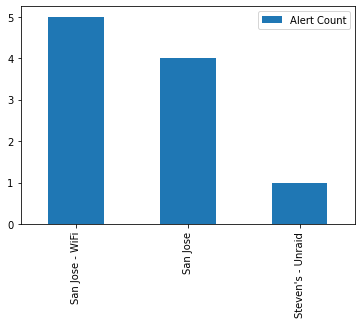

In [18]:
to_plot.plot.bar()